# GHS Model

This notebook runs the code based upon the model in the paper "An analytical performance model of generalized hierarchical scheduling" by Stephen Herbein et. al. available at: https://journals.sagepub.com/doi/pdf/10.1177/10943420211051039 .

### Assumptions

A1: Job requirements (cores) are fixed over the life cycle of the job 

(Discussed herein) A2: All jobs submitted at start of workflow 

A3: All jobs are independent 

A4: Jobs have homogeneous resource and time requirements 

A5: Jobs and resources are uniformly distributed at each scheduler tree level 

A6: Scheduling rate does not vary over workflow lifetime


### Assumption 2: All jobs submitted at start of workflow

#### Scenario A: Baseline model, jobs submitted at start of workflow

Notebook showcases behavior of Assumption 2 (All jobs submitted at start of workflow) in the form of [Scenario A], a baseline without present changes. 

This notebook has an implementation of the breaking, but is configured to act as a baseline. 

## Discussed Parameters

Scenario A -- current configuration 
* N =  1219 -- total number of jobs for ATS
* B = 1 -- total number of batches
* b = b1
* nb = N -- number of jobs in b1
* t = t0  -- before run
* ∆t = N/A


## Notebook Parameters

8 nodes
40 cores per node

topo 1: 320 cores per scheduler\
Maximum overall jobs: 1024\
sleep 0

topo 1x8: 40 cores per scheduler \
jobs overall: 1024\*8 = 4096 \
sleep 0 
    
topo 1x8x40: 1 core per scheduler \
jobs overall: 1024\*8\*40 = 327,680 \
sleep 0 

In [1]:
num_nodes = 8 # Number of nodes for workflow
global cores_per_node
cores_per_node = 40 # Number of cores per node
global total_cores
total_cores = num_nodes * cores_per_node # Calculates out overall cores automatically
global sched_rate
sched_rate = 22.3 # Tested throughput of scheduler at steady-state
global sched_create_cost
sched_create_cost = 3.4 # Tested time necessary to initialize scheduler
scenario = [0] # Scenario to run (A=0, B=1, C=2. . .)

jobs_per_leaf=1024 # Jobs per leaf scheduler -- assuming jobs are assigned only to leaves

# Hierarchy topologies to be tested
topologies = [
    [1],
    [1, 8],
    #[1, num_nodes],
    [1, 8,8]
    #[1, 444, 444],
    #[1, num_nodes, cores_per_node],
    #[1, 55, 60, 60],
]

# Plotting Parameters
%matplotlib inline
LINEWIDTH = 3 # Width of line
MARKERSIZE = 10 # Size of markers (relevant for experimental data)
TEXTSIZE = "large" # Size of text on plot title
LEGEND_TEXTSIZE = "medium" # Size of text in legend
AXIS_LABELSIZE = "x-large" # Size of axis labels
FIG_HEIGHT = 4.8 # Figure height
FIG_WIDTH = 7 # Figure width
YLIM = 1000 # Maximum Y value in plot

## Setup

The following cell performs necessary setup -- imports and function definitions.

In [2]:
import os
import sys
import logging
from abc import ABC, abstractmethod
from typing import SupportsFloat, SupportsInt
from sklearn.metrics import r2_score

os.environ["NUMEXPR_MAX_THREADS"] = "16"
import numpy as np
import pandas as pd

sys.path.append("..")

from modules import util
from modules.models import model_util
from modules.models.model_util import agg_by, trim_max_jobs_per_leaf, get_num_leaves

class Model(ABC):
    def __init__(self, logger=None):
        self.level_one_interp = None
        if logger is None:
            self.logger = logging.getLogger()
        else:
            self.logger = logger

    @abstractmethod
    def get_valid_jobs_per_leaf(self):
        pass

    @abstractmethod
    def get_single_level_predictions(self, num_jobs):
        pass

    @abstractmethod
    def get_job_launch_cost(self, topology, jobs_per_leaf):
        pass

    @abstractmethod
    def get_empty_hierarchy_init_cost(self, topology):
        pass
    
    @abstractmethod
    def get_single_scheduler_predictions(self, num_scheds):
        pass
    
    

    def get_interpolated_predictions(self, topology):
        num_levels = len(topology)
        if num_levels not in [1, 2, 3]:
            raise NotImplementedError("{} levels not implemented".format(num_levels))
        elif num_levels == 1 and self.level_one_interp is not None:
            return self.level_one_interp
        prediction_df = self.get_predictions(topology)
        self.logger.debug(
            "Num-Levels: %d, Prediction DF:\n%s", num_levels, prediction_df
        )
        out_df = self.interpolate(
            prediction_df.num_jobs.to_numpy(), prediction_df.makespan.to_numpy()
        )
        out_df["num_levels"] = len(topology)
        if num_levels == 1:
            self.level_one_interp = out_df

        return out_df

    def get_predictions(self, topology):
        self.num_levels = len(topology)

        jobs_per_leaf = self.get_valid_jobs_per_leaf()
        jobs_per_leaf = jobs_per_leaf.unique()
        assert len(jobs_per_leaf) > 0

        # Case 1: Compute cost for a single scheduler.
        if self.num_levels == 1:
            num_jobs = jobs_per_leaf
            makespans = self.get_single_level_predictions(jobs_per_leaf)
            self.logger.debug(
                "Num leaves: %d, Num_jobs: %s, Makespans: %s", 1, num_jobs, makespans
            )
        # Case 2: Compute cost for full hierarchy.
        else:
            num_leaves = get_num_leaves(topology)
            # Recall that jobs_per_leaf is a progressive array, so this just handles distribution.
            num_jobs = np.array([jpl * num_leaves for jpl in jobs_per_leaf])
            self.logger.debug(
                "Num leaves: %d, Num_jobs: %s, Jobsperleaf: %s",
                num_leaves,
                num_jobs,
                jobs_per_leaf,
            )
            # This is where the callstack starts for proper computation.
            makespans = self.get_multilevel_predictions(topology, jobs_per_leaf)
        out_df = pd.DataFrame(data={"num_jobs": num_jobs, "makespan": makespans})
        out_df["num_levels"] = len(topology)
        out_df.sort_values(by="num_jobs")
        return out_df

   
    def get_multilevel_predictions(self, topology, jobs_per_leaf: np.ndarray):
        if len(topology) < 2:
            raise ValueError("Must be passed a multi-level topology")
        # Cost calculation contains the equations from the paper.
        return [self.calc_cost(topology, jpl) for jpl in jobs_per_leaf]

    @staticmethod
    def interpolate(num_jobs, makespans):
        interp_num_jobs, interp_makespans = interpolate_real_data(
            num_jobs, makespans, degree=2
        )
        return pd.DataFrame(
            data={
                "num_jobs": interp_num_jobs,
                "makespan": interp_makespans,
                "throughput": interp_num_jobs / interp_makespans,
            }
        )

    def calc_cost(self, topology, jobs_per_leaf: np.int32):
        # Correlates to Create(Tree)
        cost_to_launch_hierarchy = self.get_empty_hierarchy_init_cost(topology)
        # Only have to consider the cost at the last leaf (it is the straggler/on the critical path)
        # Equation 1 in paper
        cost_to_launch_jobs = self.get_job_launch_cost(topology, jobs_per_leaf)
        # Equation 6 in paper
        total_cost = cost_to_launch_hierarchy + cost_to_launch_jobs
        self.logger.log(
            9,
            "Level-{}, jobsperleaf: {:4d}, hierarchy_launch: {:4.1f}, job_launch: {:7.1f}, total: {:7.1f}".format(
                len(topology),
                jobs_per_leaf,
                cost_to_launch_hierarchy,
                cost_to_launch_jobs,
                total_cost,
            ),
        )
        return total_cost

    @abstractmethod
    def calc_model_cost(self):
        pass
    


class AnalyticalModel(Model):
    def __init__(
        self,
        sched_rate: SupportsFloat,
        sched_create_cost: SupportsFloat,
        resource_cap: SupportsFloat,
        max_jobs_per_leaf: SupportsInt,
        logger=None,
    ):
        """
        sched_rate is the maximum throughput, in jobs per second, that a given
        scheduler implementation can achieve on a resource unconstrained system.
        resource_cap is the maximum number of jobs that can be running
        simultaneously due to resource capacity constraints
        """
        super().__init__(logger=logger)
        self.sched_rate = float(sched_rate)
        self.sched_create_cost = float(sched_create_cost)
        self.resource_cap = float(resource_cap)
        self.max_jobs_per_leaf = int(max_jobs_per_leaf)

    @abstractmethod
    def get_single_level_predictions(self, num_jobs: np.ndarray, resource_cap=None, runtime=None):
        pass
    
    @abstractmethod
    def get_single_scheduler_predictions(self, num_scheds: np.ndarray, resource_cap=None, runtime=None):
        pass

    @abstractmethod
    def calc_model_cost(self):
        pass

    def get_valid_jobs_per_leaf(self):
        return pd.Series(data=np.arange(1, self.max_jobs_per_leaf + 1, dtype=np.int32))

    def get_interpolated_predictions(self, topology):
        # No need for interpolation with this inexpensive analytical model
        pred_df = self.get_predictions(topology)
        pred_df["throughput"] = pred_df.num_jobs / pred_df.makespan
        return pred_df

    # Works towards filling out equation 1 from paper
    def get_job_launch_cost(self, topology, jobs_per_leaf: pd.Series):
        num_leaves = get_num_leaves(topology)
        return self.get_single_level_predictions(
            np.array([jobs_per_leaf]), resource_cap=self.resource_cap / num_leaves
        )[0]

     # Finds the cost for tree creation.
     # Equation 3 in paper
    def get_empty_hierarchy_init_cost(self, topology):
        if len(topology) == 0:
            return 0
        return self.get_single_scheduler_predictions(np.array([topology[-1]]), runtime=0)[
            0
        ] + self.get_empty_hierarchy_init_cost(topology[:-1])
    


## Setup -- Scenario A Implementation

The following cell contains the calculation of a single scheduler's performance, and, thus, is placed aside, as an important focus of this work.

In [4]:
class AnalyticalModelContentedRuntime(AnalyticalModel):
    def __init__(
        self,
        sched_rate: SupportsFloat,
        sched_create_cost: SupportsFloat,
        resource_cap: SupportsFloat,
        avg_runtime_func,
        cores_per_node,
        max_jobs_per_leaf=1024,
        logger=None
    ):
        """
        sched_rate is the maximum throughput, in jobs per second, that a given
        scheduler implementation can achieve on a resource unconstrained system.
        resource_cap is the maximum number of jobs that can be running
        simultaneously due to resource capacity constraints
        """
        super().__init__(sched_rate, sched_create_cost, resource_cap, max_jobs_per_leaf, logger=logger)

        self.get_avg_runtime = avg_runtime_func
        self.cores_per_node = cores_per_node

    # Calculates equation 1 in paper.
    def get_single_level_predictions(self, num_jobs: np.ndarray, resource_cap=None, runtime=None):
        if resource_cap is None:
            resource_cap = self.resource_cap  # assume we are using the whole system
        if runtime is None:
            runtime = self.get_avg_runtime(num_jobs, resource_cap)
        # First draft of breaking assumption 2: Modifying sched rate to match 
        # the slowdown of waiting incessantly. 
        local_sched_rate = self.sched_rate
        sched_bottleneck = num_jobs / local_sched_rate
        resource_bottleneck = (
            num_jobs * runtime
        ) / num_jobs.clip(
            max=resource_cap
        )  # clip(max=X) sets all values greater than X to X.  equivalent to .apply(lambda x: min(x, X))
            
        true_bottleneck = np.maximum(sched_bottleneck, resource_bottleneck)
        init_cost = self.sched_create_cost
        return true_bottleneck + init_cost
    
    # Calculates equation 1 in paper, without wait influencing.
    def get_single_scheduler_predictions(self, num_jobs: np.ndarray, resource_cap=None, runtime=None):
        if resource_cap is None:
            resource_cap = self.resource_cap  # assume we are using the whole system
        if runtime is None:
            runtime = self.get_avg_runtime(num_jobs, resource_cap)
        sched_bottleneck = num_jobs / self.sched_rate
        resource_bottleneck = (
            num_jobs * runtime
        ) / num_jobs.clip(
            max=resource_cap
        )  # clip(max=X) sets all values greater than X to X.  equivalent to .apply(lambda x: min(x, X))
        true_bottleneck = np.maximum(sched_bottleneck, resource_bottleneck)
        init_cost = self.sched_create_cost
        return true_bottleneck + init_cost

    def calc_model_cost(self):
        num_waves = 3
        contention_test = (
            self.get_avg_runtime(self.cores_per_node * num_waves, self.cores_per_node)
            * num_waves
        )
        return (contention_test, contention_test)

In [5]:
from __future__ import print_function

import os
import argparse
import logging
import functools
import itertools
import multiprocessing as mp
import sys

os.environ["NUMEXPR_MAX_THREADS"] = "16"
import numpy as np
import pandas as pd




def create_model(unique_id, scenario):
    return AnalyticalModelContentedRuntime(
        sched_rate=sched_rate,
        sched_create_cost=sched_create_cost,
        resource_cap=total_cores,
        avg_runtime_func=functools.partial(model_util.get_avg_runtime, unique_id, system="lassen"),
        cores_per_node=cores_per_node,
        max_jobs_per_leaf=jobs_per_leaf,
        logger=logger
    )

def gen_df(topology, unique_id, scenario):
    analyticalWithContention_model = create_model(unique_id, scenario)
    df = analyticalWithContention_model.get_interpolated_predictions(topology)
    df["unique_id"] = unique_id
    df["topology"] = "x".join([str(x) for x in topology])
    df["throughput_upperbound"] = df["num_jobs"].apply(
        lambda x: model_util.calc_upperbound(unique_id, x, total_cores)
    )
    return df


def parallel_gen_df(tupl):
    return gen_df(*tupl)






## Running Model

The following cell runs the model, currently requires user-editing of values. Will switch to ipywidget.

In [6]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("model_scale_study")

unique_ids = ["sleep0"]
func_args = itertools.product(topologies, unique_ids, scenario)
with mp.Pool() as pool:
    dfs = pool.map(parallel_gen_df, func_args)

model = create_model("sleep5", 1)
for topology in topologies:
    create_time = model.get_empty_hierarchy_init_cost(topology)
    logger.info("Topology %s is predicted to take %f seconds to create", topology, create_time)

scen_a_df = pd.concat(dfs, sort=True)
scen_a_df["model_type"] = "analyticalWithContention"
util.pretty_log_df(scen_a_df, "Final DataFrame", logger)
#print(new_model_df)

#logger.info("Saving data to {}".format("assump2_mod_sched_notebook_decaying_correction.pkl"))
#new_model_df.to_pickle("assump2_mod_sched_notebook_decaying_correction.pkl")




INFO:model_scale_study:Topology [1] is predicted to take 3.444843 seconds to create
INFO:model_scale_study:Topology [1, 8] is predicted to take 7.203587 seconds to create
INFO:model_scale_study:Topology [1, 8, 8] is predicted to take 10.962332 seconds to create


## Plotting Model - Setup

The following cell performs necessary imports and function definitions to plot model output.

In [5]:
from __future__ import print_function

import re
import os
import json
import math
import argparse
import itertools
import logging
import sys
from datetime import timedelta
import glob

import matplotlib

matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import six.moves
from experiment_analysis import ExperimentData
from scipy import stats

sys.path.append("..")

from modules import util


def add_suffix_to_label(label, base=2):
    if base == 2:
        divisor = 1024
    elif base == 10:
        divisor = 1000
    else:
        raise NotImplementedError()

    if label < 1000:
        return label
    elif label < 1_000_000:
        return "{:d}K".format(int(label // divisor))
    elif label < 1_000_000_000:
        return "{:d}M".format(int(label // math.pow(divisor, 2)))
    elif label < 1_000_000_000_000:
        return "{:d}B".format(int(label // math.pow(divisor, 3)))
    else:
        raise NotImplementedError()


def setup_fig(fig, ax, no_yaxis=False):
    global YLIM
    ax.set_xscale("log", basex=2)
    ax.set_yscale("log")
    xtick_locs = [int(math.pow(4, x)) for x in range(0, 18)]
    plt.xticks(
        xtick_locs,
        [add_suffix_to_label(tick) for tick in xtick_locs],
        rotation="vertical",
        fontsize=TEXTSIZE,
    )
    ytick_locs = [0] + [int(math.pow(10, x)) for x in range(0, 7)]
    plt.yticks(
        ytick_locs,
        [add_suffix_to_label(tick, 10) for tick in ytick_locs],
        rotation="horizontal",
        fontsize=TEXTSIZE,
    )

    #ax.set_xlim(0.8, 1048576 * 1.2)
    ax.set_xlim(0.8, 4500 * 44 * 32768 * 1.4)
    ax.set_ylim(0.1, YLIM)
    ax.grid(axis="y", which="major", color="black")
    #ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    locmin = matplotlib.ticker.LogLocator(
        base=10.0, subs=np.arange(2, 10) * 0.1, numticks=40
    )
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.set_xlabel("Number of jobs (total)", fontweight="bold", fontsize=AXIS_LABELSIZE)
    ax.set_ylabel(
        "Avg. Throughput (jobs/sec)", fontweight="bold", fontsize=AXIS_LABELSIZE
    )
    ax.tick_params(axis="y", which="minor", left=True, top=True)

def log_range(range_min, range_max, base=2):
    return itertools.takewhile(
        lambda x: x <= range_max,
        [
            math.pow(base, x)
            for x in six.moves.range(
                int(math.floor(math.log(range_min, base))),
                int(math.ceil(math.log(range_max, base)) + 1),
            )
        ],
    )


def read_experiment(dirname, topos):
    datas = []
    counter = 0
    for topo in topos:
        dirs = glob.glob(dirname.format(topo))
        datas.append([])
        for dir in dirs:
            datas[counter].append([ExperimentData("{}/out/{}".format(dir, i)) for i in range(0,3)])
        counter += 1
    for dataset in datas:
        dataset.sort(key=lambda data: sum(data[0].total_jobs().values()))
    return datas

def calc_R2(model_df, level, exp_x, exp_y):
    R2_df = model_df
    R2_df = R2_df.loc[R2_df['num_jobs'].isin(exp_x)]
    R2_df = R2_df.loc[R2_df['num_levels'] == level]
    comp = R2_df['throughput']
    print(r2_score(exp_y, list(comp)), "Topology ", level)

def plot_model(model_df, ax, topos, unique_id):
    legend_handles = []
    model_df = model_df.sort_values(by=["num_jobs"])
    label = "throughput"

    level_color_map = {
        1: "red",
        2: "blue",
        3: "green",
        4: "orange",
    }
    # for level, color_char, line_label in [
    #     (1, "r", "1-Level"),
    #     (2, "b", "2-Level"),
    #     (3, "g", "3-Level"),
    # ]:
    def get_num_levels(topology):
        return len(topology.split('x'))

    def get_topology_order(topology):
        topo = [int(x) for x in topology.split('x')]
        num_levels = len(topo)
        if num_levels == 1:
            return (1, 1)
        if topo[1] == 32:
            return (1, num_levels)
        return (2, num_levels)

    datas = read_experiment("/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/ass2_ScenA/topo{}/*", topos)
    counter = 0
    for dataset in datas:
        xs = []
        ys = []
        linestyle = "-"
        color = level_color_map[counter+1]
        for entry in dataset:
            xs.append(sum(entry[0].total_jobs().values()))
            ys.append(entry[0].total_job_throughput())
        line_2d = ax.plot(xs, ys, color=color, linewidth=0, label="Experimental {}".format(topos[counter]), marker="D", markersize=2)
        assert len(line_2d) == 1
        calc_R2(model_df, counter+1, xs, ys)
        legend_handles.append(line_2d.pop())
        counter += 1
    
    for topology in sorted(model_df['topology'].unique(), key=get_topology_order):
        level_df = model_df[model_df.topology == topology]
        num_levels = get_num_levels(topology)
        if num_levels == 1 or int(topology.split('x')[1]) == 32:
            linestyle = "solid"
        else:
            linestyle = "solid"
        color = level_color_map[num_levels]
        Xs = level_df["num_jobs"]
        Ys = level_df[label]
        line_2d = ax.plot(Xs, Ys, color=color, linestyle=linestyle, label=topology)
        assert len(line_2d) == 1
        legend_handles.append(line_2d.pop())


    return legend_handles

## Plotting Model - Run

The following cell runs plotting code for the model. Note that it does not currently take into account experimental data.

In [8]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("plot_model_scale_study")
def plot_df(df, figtitle, topos, to_pdf=None):
    

    #scale_up_df = pd.read_pickle("assump2_mod_sched_notebook_decaying_correction.pkl")
    scale_up_df = df
    assert len(scale_up_df) > 0

    for idx, unique_id in enumerate(scale_up_df['unique_id'].unique()):
        app_model_df = scale_up_df[scale_up_df.unique_id == unique_id]

        fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
        setup_fig(fig, ax, no_yaxis=(idx > 0))

        legend_handles = plot_model(app_model_df, ax, topos, unique_id)

        loc = "upper right"
        legend = plt.legend(
            handles=legend_handles,
            loc=loc,
            title="Tree:",
            frameon=True,
            framealpha=1,
            title_fontsize=LEGEND_TEXTSIZE,
            prop={"size": LEGEND_TEXTSIZE},
        )
        legend.get_title().set_weight("bold")

        #if args.nofig:
        #    pass
        #elif args.savefig is not None:
        #    plt.tight_layout()
        #    filename = "{0}_scale_up.pdf".format(unique_id)
        #    logger.info("Saving to %s", filename)
        #    plt.savefig(filename, bbox_inches="tight")
        #else:
        if to_pdf is None:
            plt.title(figtitle)
            plt.show()
        else:
            plt.title(figtitle)
            plt.tight_layout()
            filename = to_pdf
            logger.info("Saving to %s", to_pdf)
            plt.savefig(to_pdf, bbox_inches="tight")

<ipython-input-7-54484be3b09c>:52: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=2)


0.8513668585575719 Topology  1
0.8460885041408213 Topology  2
0.9716895068636849 Topology  3


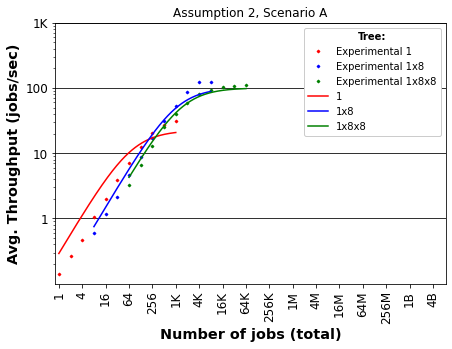

In [9]:
%matplotlib inline
plot_df(scen_a_df, "Assumption 2, Scenario A", ["1", "1x8", "1x8x8"])

# No waits, no batches -- jobs all submitted at start of workflow, up to 1024 per leaf. 

0.8513668585575719 Topology  1
0.8460885041408213 Topology  2
0.9716895068636849 Topology  3


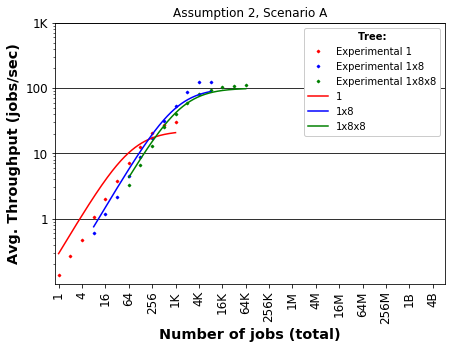

In [8]:
%matplotlib inline
plot_df(scen_a_df, "Assumption 2, Scenario A")

# No waits, no batches -- jobs all submitted at start of workflow, up to 1024 per leaf. 

In [11]:
dirs = glob.glob("/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/param_sweep_lassen_test/*")

In [12]:
print(dirs)

['/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/param_sweep_lassen_test/topo1', '/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/param_sweep_lassen_test/topo1x8', '/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/param_sweep_lassen_test/topo1x8x8']


In [18]:
import re

def read_experiment(dirname, exp_num):
    experiment_dir = dirname.split('/')[-1]
    props = experiment_dir.split('-')
    experiment = [None, None, None, None, None, None, None]
    experiment[0] = int(re.findall(r'\d+', props[1])[0])
    experiment[1] = int(re.findall(r'\d+', props[2])[0])
    experiment[2] = int(re.findall(r'\d+', props[3])[0])
    experiment[3] = props[11]
    experiment[4] = props[13]
    experiment[5] = props[15]
    experiment[6] = ExperimentData("{}/out/{}".format(dirname, exp_num))
    return experiment

    
    

def read_experiment_dir(dirname, topos):
    datas = []
    counter = 0
    for topo in topos:
        dirs = glob.glob(dirname + topo + "/*")
        print(dirs)
        for dir in dirs:
            datas.append(read_experiment(dir, 0))
            pass
        
            
        counter += 1
    print(datas)
    print(pd.DataFrame(datas,columns=["nodes", "cores", "topo", "batch_size", "wait", "joblen", "data"]))
    #for dataset in datas:
    #    dataset.sort(key=lambda data: sum(data[0].total_jobs().values()))
    return datas

read_experiment_dir("/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/param_sweep_lassen_test/", ["topo1"])

['/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/param_sweep_lassen_test/topo1/lassen-8nodes-320cores-topo1-vary-none-dist-rr-unshuffled-sync-batch-8-wait-0-joblen-0', '/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/param_sweep_lassen_test/topo1/lassen-8nodes-320cores-topo1-vary-none-dist-rr-unshuffled-sync-batch-8-wait-0-joblen-5', '/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/param_sweep_lassen_test/topo1/lassen-8nodes-320cores-topo1-vary-none-dist-rr-unshuffled-sync-batch-8-wait-5-joblen-0', '/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/param_sweep_lassen_test/topo1/lassen-8nodes-320cores-topo1-vary-none-dist-rr-unshuffled-sync-batch-8-wait-5-joblen-5', '/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/param_sweep_lassen_test/topo1/lassen-8nodes-320cores-topo1-vary-none-dist-rr-unshuffled-sync-batch-16-wait-0-joblen-0', '/g/g16/suarez29/work/Project_LLNL_Cla

[[8,
  320,
  1,
  '8',
  '0',
  '0',
 [8,
  320,
  1,
  '8',
  '0',
  '5',
 [8,
  320,
  1,
  '8',
  '5',
  '0',
 [8,
  320,
  1,
  '8',
  '5',
  '5',
 [8,
  320,
  1,
  '16',
  '0',
  '0',
 [8,
  320,
  1,
  '16',
  '0',
  '5',
 [8,
  320,
  1,
  '16',
  '5',
  '0',
 [8,
  320,
  1,
  '16',
  '5',
  '5',

In [7]:
practice = '/g/g16/suarez29/work/Project_LLNL_ClarkSebastian/ats-experiments/output/param_sweep_lassen_test/topo1/lassen-8nodes-320cores-topo1-vary-none-dist-rr-unshuffled-sync-batch-8-wait-0-joblen-0'

In [8]:
print(practice.split('/'))

['', 'g', 'g16', 'suarez29', 'work', 'Project_LLNL_ClarkSebastian', 'ats-experiments', 'output', 'param_sweep_lassen_test', 'topo1', 'lassen-8nodes-320cores-topo1-vary-none-dist-rr-unshuffled-sync-batch-8-wait-0-joblen-0']


In [10]:
print(practice.split('/')[-1].split('-'))

['lassen', '8nodes', '320cores', 'topo1', 'vary', 'none', 'dist', 'rr', 'unshuffled', 'sync', 'batch', '8', 'wait', '0', 'joblen', '0']


In [12]:
print(practice.split('/')[-1].split('-')[11])

8


In [13]:
print(practice.split('/')[-1].split('-')[13])

0


In [14]:
print(practice.split('/')[-1].split('-')[15])

0


In [15]:
import pandas as pd

In [18]:
pd.DataFrame(columns=["nodes", "cores", "topo", "batch_size", "wait", "joblen", "data"])

,nodes,cores,topo,batch_size,wait,joblen,data
